<a href="https://colab.research.google.com/github/LorenaVF99/DanoneHackathonDS/blob/main/Danone_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import json
import numpy as np

#Modelo
from sklearn.linear_model import LogisticRegression

#Gráficas
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [2]:
#lectura del archivo JSON

url = "https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Danone+Hackathon+Mexico/data/train_products.json"

response = requests.get(url)
data = response.json()

Comenzaremos por evaluar las características de los datos en un panorama general (incluyendo detalles que podrían explicar la elección o descarte de algunas variables). Aquellas que parecen tener una correlación mayor con la variable objetivo ***ecoscore-grade*** son:
* ***non_recyclable_and_non_biodegradable_materials_count***: Como su nombre lo indica da indicios de los residuos que se generarán después del consumo del producto.
* ***est_co2_agriculture***: Emisiones provenientes de la agricultura. En unidades de kg Co2eq / kg de producto
* ***est_co2_consumption***: Emisiones debido al consumo (por ejemplo, las emisiones correspondientes al proceso de cocinar un producto).
* ***est_co2_distribution***: Emisiones debidas al proceso de distribución del producto terminado hacia los puntos de venta (p. ej. supermercados).
* ***est_co2_packaging***: Emisiones debidas al proceso de manufactura de los envases.
* ***est_co2_processing***: Emisiones debidas al proceso de producción del producto.
* ***est_co2_transportation***: Emisiones debidas al proceso de transporte (que incluye transporte de ingredientes

<font color="blue"> A evaluar: </font>

* *categories_hierarchy*: Podría dar indicios de los costos de almacenamiento.
* *ingredient_origins*: Relacionado con los costos de producción y transporte
* *vegan/vegetarian*: Indica si los productos provienen de origen animal o no, lo cual está relacionado con mayores emisiones de carbono.
* *additives_count*: Existen algunos aditivos que son potencialmente contaminantes (derivados del alquitrán, benzoatos, sorbatos, aspartame, sucralosa, esteres de acidos grasos, fosfatos). Representan un peligro al entrar en contacto con agua en los procesos de lavado, limpieza y fabricación, al estar presentes como residuos en los envases, por liberación durante su uso y prácticas de manipulación inadecuadas.
* *ingredients*: Podemos seleccionar aquellos que son potencialmente contaminantes.
* *salt/sodium*: Puede representar un problema para los cuerpos de agua
* *sugars* : Requiere grandes cantidades de suelo y agua para su producción
* *packaging_materials*: Hay materiales de envase altamente contaminantes

In [3]:
data1 = {}

#Creación de un nuevo diccionario con llaves enteras
for key, value in data.items():
  new_key= int(key)
  data1[new_key] = value

#Obtención de los datos que nos interesan (expresados arriba) en forma de listas
id = data1.keys()
additives_count = [ data1[i]["additives_count"] for i in range (0,len(data1))]
salt_100g = [ data1[i]["salt_100g"] for i in range (0,len(data1))]
sodium_100g = [ data1[i]["sodium_100g"] for i in range (0,len(data1))]
sugars_100g = [ data1[i]["sugars_100g"] for i in range (0,len(data1))]
non_recyclable_and_non_biodegradable_materials_count = [ data1[i]["non_recyclable_and_non_biodegradable_materials_count"] for i in range (0,len(data1))]
est_co2_agriculture = [ data1[i]["est_co2_agriculture"] for i in range (0,len(data1))]
est_co2_consumption = [ data1[i]["est_co2_consumption"] for i in range (0,len(data1))]
est_co2_distribution = [ data1[i]["est_co2_distribution"] for i in range (0,len(data1))]
est_co2_packaging = [ data1[i]["est_co2_packaging"] for i in range (0,len(data1))]
est_co2_processing = [ data1[i]["est_co2_processing"] for i in range (0,len(data1))]
est_co2_transportation = [ data1[i]["est_co2_transportation"] for i in range (0,len(data1))]
ecoscore_grade = [ data1[i]["ecoscore_grade"] for i in range (0,len(data1))]
is_vegan=[]
is_vegetarian=[]

#Conteo de ingredientes no-veganos y no-vegetarianos para cada producto
for j in range(0,len(data1)):
  not_vegan=0
  not_vegetarian =0
  for i  in data1[j]["ingredients"]:
    if "vegan" not in i:
      continue
    if i["vegan"] == "no":
      not_vegan += 1
    if i["vegetarian"] == "no":
      not_vegetarian += 1
  is_vegan.append(not_vegan)
  is_vegetarian.append(not_vegetarian)


#Transformar todas las entradas a número
co2_agriculture = [float(i) for i in est_co2_agriculture]
co2_consumption = [float(i) for i in est_co2_consumption]
co2_distribution = [float(i) for i in est_co2_distribution]
co2_packaging = [float(i) for i in est_co2_packaging]
co2_processing = [float(i) for i in est_co2_processing]
co2_transportation = [float(i) for i in est_co2_transportation]

In [4]:
#Crear DataFrame de pandas

datos = pd.DataFrame({
    "ID": id,
    "additives_count": additives_count,
    "salt_100g": salt_100g,
    "sodium_100g": sodium_100g,
    "sugars_100g": sugars_100g,
    "non_recyclable_and_non_biodegradable_materials_count": non_recyclable_and_non_biodegradable_materials_count,
    "est_co2_agriculture": co2_agriculture,
    "est_co2_consumption": co2_consumption,
    "est_co2_distribution": co2_distribution,
    "est_co2_packaging": co2_packaging,
    "est_co2_processing": co2_processing,
    "est_co2_transportation": co2_transportation,
    "is_vegan": is_vegan,
    "is_vegetarian": is_vegetarian,
    "ecoscore_grade": ecoscore_grade
})

Comenzaremos por estudiar ahora las entradas de cada columna de forma general, para saber si hay datos faltantes/nulos, su tipo, así como otras características.

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 15 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   ID                                                    20835 non-null  int64  
 1   additives_count                                       20835 non-null  object 
 2   salt_100g                                             20835 non-null  object 
 3   sodium_100g                                           20835 non-null  object 
 4   sugars_100g                                           20835 non-null  object 
 5   non_recyclable_and_non_biodegradable_materials_count  20835 non-null  int64  
 6   est_co2_agriculture                                   20835 non-null  float64
 7   est_co2_consumption                                   20835 non-null  float64
 8   est_co2_distribution                                  20

Exploremos el tipo de datos que hay en las variables *addtives_count, salt_100g, sodium_100g y sugars_100g* usando el método *df.value_counts()*

In [6]:
print(datos["additives_count"].value_counts())

0          6017
unknown    5154
1          2879
2          2123
3          1459
4          1145
5           728
6           467
7           320
8           229
9           132
10           67
11           43
12           23
14           15
13           15
15           11
16            3
17            2
18            1
19            1
20            1
Name: additives_count, dtype: int64


In [7]:
print(datos["salt_100g"].value_counts())

unknown    2575
0          2030
0.1         880
1           493
0.01        438
           ... 
18.1          1
1.6002        1
0.0992        1
26.6          1
0.313         1
Name: salt_100g, Length: 1486, dtype: int64


In [8]:
print(datos["sodium_100g"].value_counts())

unknown    2575
0          2032
0.04        880
0.4         457
0.004       438
           ... 
7.24          1
0.64008       1
0.0397        1
10.64         1
1.2551        1
Name: sodium_100g, Length: 1474, dtype: int64


In [9]:
print(datos["sugars_100g"].value_counts())

unknown    2410
0          1730
0.5        1201
1           418
11          312
           ... 
14.2857       1
36.8          1
45.5          1
74.36         1
28.3          1
Name: sugars_100g, Length: 1329, dtype: int64


Dado que la cantidad de datos en la categoría "unknown" es alta para considerar eliminarlos, los sustituiremos por la media (para así mantener la tendencia central de los datos).

In [10]:
# Cálculo de la media de los valores numéricos: additives
numeros = [i for i in additives_count if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
additives = [media if valor == "unknown" else valor for valor in additives_count]

# Cálculo de la media de los valores numéricos: salt
numeros1 = [i for i in salt_100g if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
salt = [media if valor == "unknown" else valor for valor in salt_100g]
salt_100g = [float(i) for i in salt]

# Cálculo de la media de los valores numéricos: sodium
numeros2 = [i for i in sodium_100g if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
sodium = [media if valor == "unknown" else valor for valor in sodium_100g]
sodium_100g = [float(i) for i in sodium]

# Cálculo de la media de los valores numéricos: sugars
numeros3 = [i for i in sugars_100g if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
sugars = [media if valor == "unknown" else valor for valor in sugars_100g]
sugars_100g = [float(i) for i in sugars]



## Actualización del DataFrame

In [11]:
#Crear DataFrame de pandas

datos = pd.DataFrame({
    "ID": id,
    "additives_count": additives,
    "salt_100g": salt_100g,
    "sodium_100g": sodium_100g,
    "sugars_100g": sugars_100g,
    "non_recyclable_and_non_biodegradable_materials_count": non_recyclable_and_non_biodegradable_materials_count,
    "est_co2_agriculture": co2_agriculture,
    "est_co2_consumption": co2_consumption,
    "est_co2_distribution": co2_distribution,
    "est_co2_packaging": co2_packaging,
    "est_co2_processing": co2_processing,
    "est_co2_transportation": co2_transportation,
    "is_vegan": is_vegan,
    "is_vegetarian": is_vegetarian,
    "ecoscore_grade": ecoscore_grade
})

In [12]:
print(datos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 15 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   ID                                                    20835 non-null  int64  
 1   additives_count                                       20835 non-null  float64
 2   salt_100g                                             20835 non-null  float64
 3   sodium_100g                                           20835 non-null  float64
 4   sugars_100g                                           20835 non-null  float64
 5   non_recyclable_and_non_biodegradable_materials_count  20835 non-null  int64  
 6   est_co2_agriculture                                   20835 non-null  float64
 7   est_co2_consumption                                   20835 non-null  float64
 8   est_co2_distribution                                  20

Usaremos el método *df.describe()* para encontrar otros atributos

In [13]:
datos.describe()

,ID,additives_count,salt_100g,sodium_100g,sugars_100g,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,is_vegan,is_vegetarian,ecoscore_grade
count,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000,20835.000000
mean,10417.000000,1.907531,1.235505,0.637964,12.512749,0.740725,2.790629,0.019210,0.028538,0.258413,1.069223,0.250198,1.209887,0.289129,2.149028
std,6014.690765,2.048185,7.532086,3.067900,17.737173,0.457327,3.657298,0.062840,0.016975,0.437369,2.686344,0.201088,2.066607,0.936403,1.221355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002275,0.000000,0.000000,0.000000
25%,5208.500000,0.000000,0.110000,0.044000,1.100000,0.000000,0.728181,0.000000,0.017321,0.123766,0.150109,0.184168,0.000000,0.000000,1.000000
50%,10417.000000,1.907531,0.700000,0.280000,3.330000,1.000000,1.530274,0.006688,0.022707,0.226134,0.251694,0.213400,0.000000,0.000000,2.000000
75%,15625.500000,2.000000,1.700000,0.680000,19.000000,1.000000,3.977171,0.010931,0.037049,0.281544,0.665622,0.266267,2.000000,0.000000,3.000000
max,20834.000000,20.000000,600.000000,240.000000,105.000000,4.000000,51.221154,1.285926,0.205742,9.769783,19.052315,7.799588,31.000000,17.000000,4.000000


## Exploración de los datos

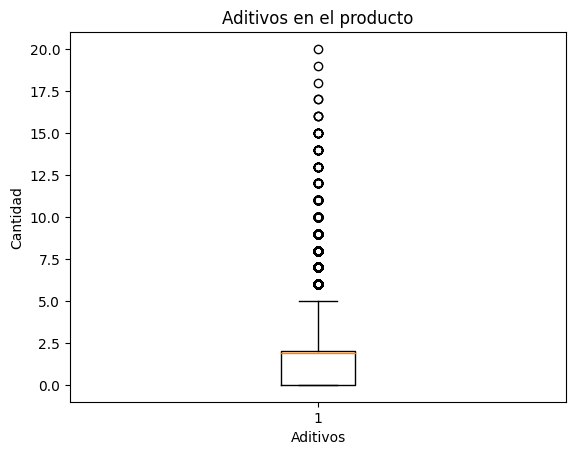

In [14]:
fig, ax = plt.subplots()
ax.boxplot(datos["additives_count"])
ax.set_title("Aditivos en el producto")
plt.xlabel('Aditivos')
plt.ylabel('Cantidad')

plt.show()





El número de aditivos se encuentra entre 0 a 5. De 5 en adelante se consideran outliers. Los datos están sesgados.

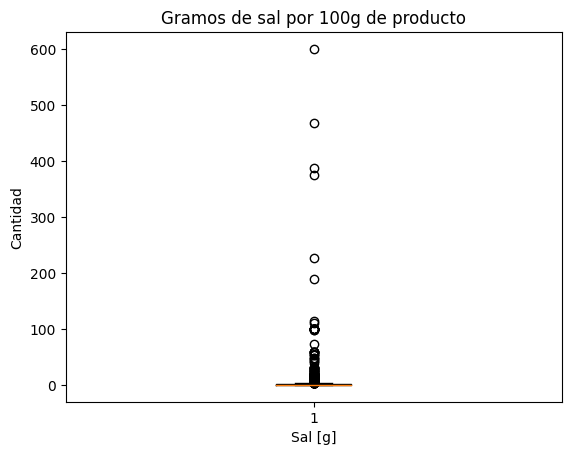

In [15]:
fig, ax = plt.subplots()
ax.boxplot(datos["salt_100g"])
ax.set_title("Gramos de sal por 100g de producto")
plt.xlabel('Sal [g]')
plt.ylabel('Cantidad')

plt.show()

Con esta gráfica podemos observar que hay productos que según el registro tienen más gramos de sal que el total del peso de producto, lo cual no tiene sentido. Por lo cual también vamos a reemplazar estos datos por la media:

In [16]:
# Cálculo de la media de los valores numéricos: salt
numeros1 = [i for i in datos["salt_100g"] if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
salt = [media if valor > 100.0 else valor for valor in salt_100g]

datos["salt_100g"]=salt


Graficamos nuevamente para esta categoría:

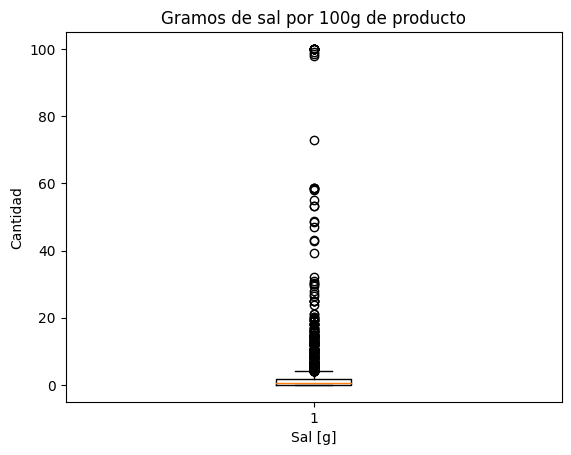

In [17]:
fig, ax = plt.subplots()
ax.boxplot(datos["salt_100g"])
ax.set_title("Gramos de sal por 100g de producto")
plt.xlabel('Sal [g]')
plt.ylabel('Cantidad')

plt.show()

Para el sodio:


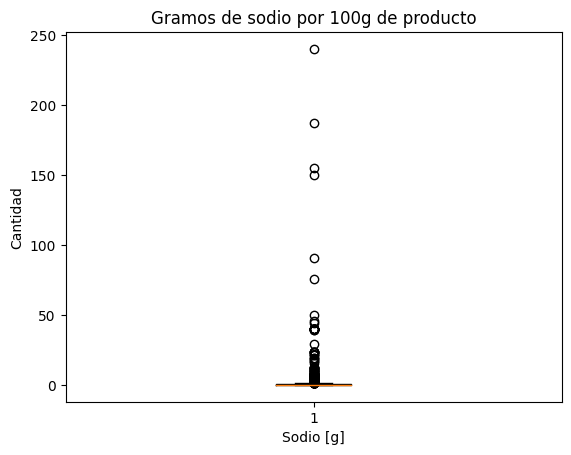

In [18]:
fig, ax = plt.subplots()
ax.boxplot(datos["sodium_100g"])
ax.set_title("Gramos de sodio por 100g de producto")
plt.xlabel('Sodio [g]')
plt.ylabel('Cantidad')

plt.show()

Nuevamente reemplazaremos por la media a aquellos datos cuyo contenido en sodio sea mayor a 100g:

In [19]:
# Cálculo de la media de los valores numéricos: sodium
numeros1 = [i for i in datos["sodium_100g"] if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
sodium = [media if valor > 100.0 else valor for valor in sodium_100g]

datos["sodium_100g"]=sodium

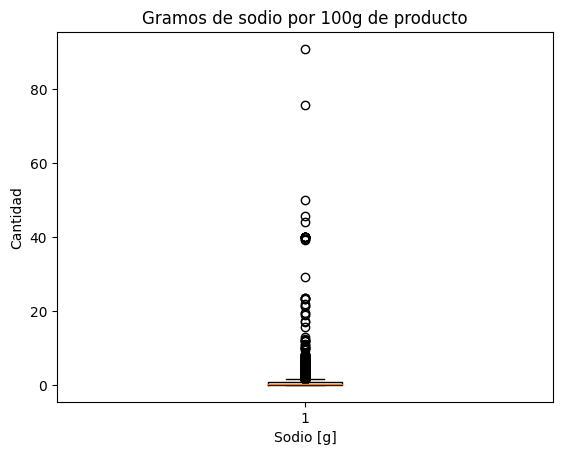

In [20]:
fig, ax = plt.subplots()
ax.boxplot(datos["sodium_100g"])
ax.set_title("Gramos de sodio por 100g de producto")
plt.xlabel('Sodio [g]')
plt.ylabel('Cantidad')

plt.show()

Finalmente, para los azúcares:

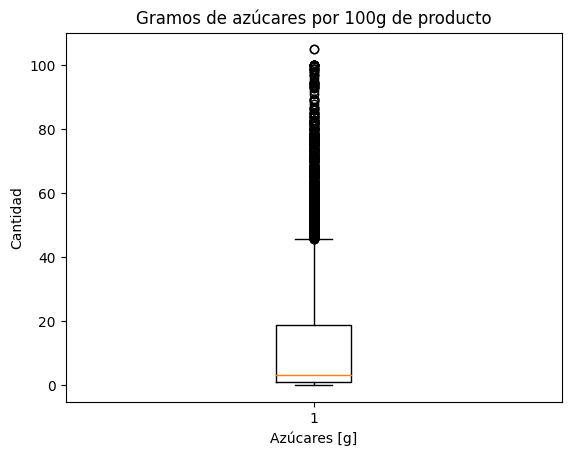

In [21]:
fig, ax = plt.subplots()
ax.boxplot(datos["sugars_100g"])
ax.set_title("Gramos de azúcares por 100g de producto")
plt.xlabel('Azúcares [g]')
plt.ylabel('Cantidad')

plt.show()

In [22]:
# Cálculo de la media de los valores numéricos: sugars
numeros1 = [i for i in datos["sugars_100g"] if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
sugars = [media if valor > 100.0 else valor for valor in sugars_100g]

datos["sugars_100g"]=sugars

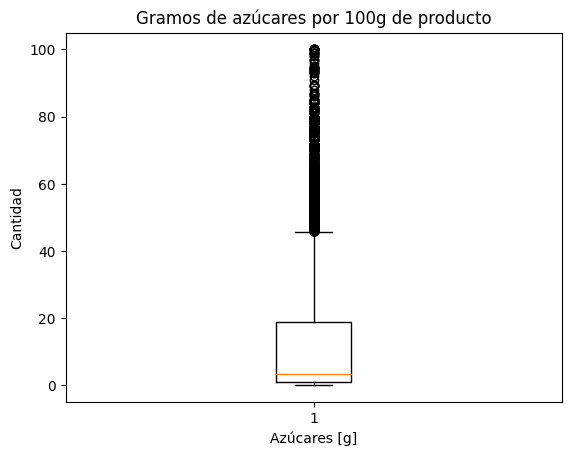

In [23]:
fig, ax = plt.subplots()
ax.boxplot(datos["sugars_100g"])
ax.set_title("Gramos de azúcares por 100g de producto")
plt.xlabel('Azúcares [g]')
plt.ylabel('Cantidad')

plt.show()

Y en general podemos encontrar histogramas para cada una de las variables usando el método *df.hist()*:

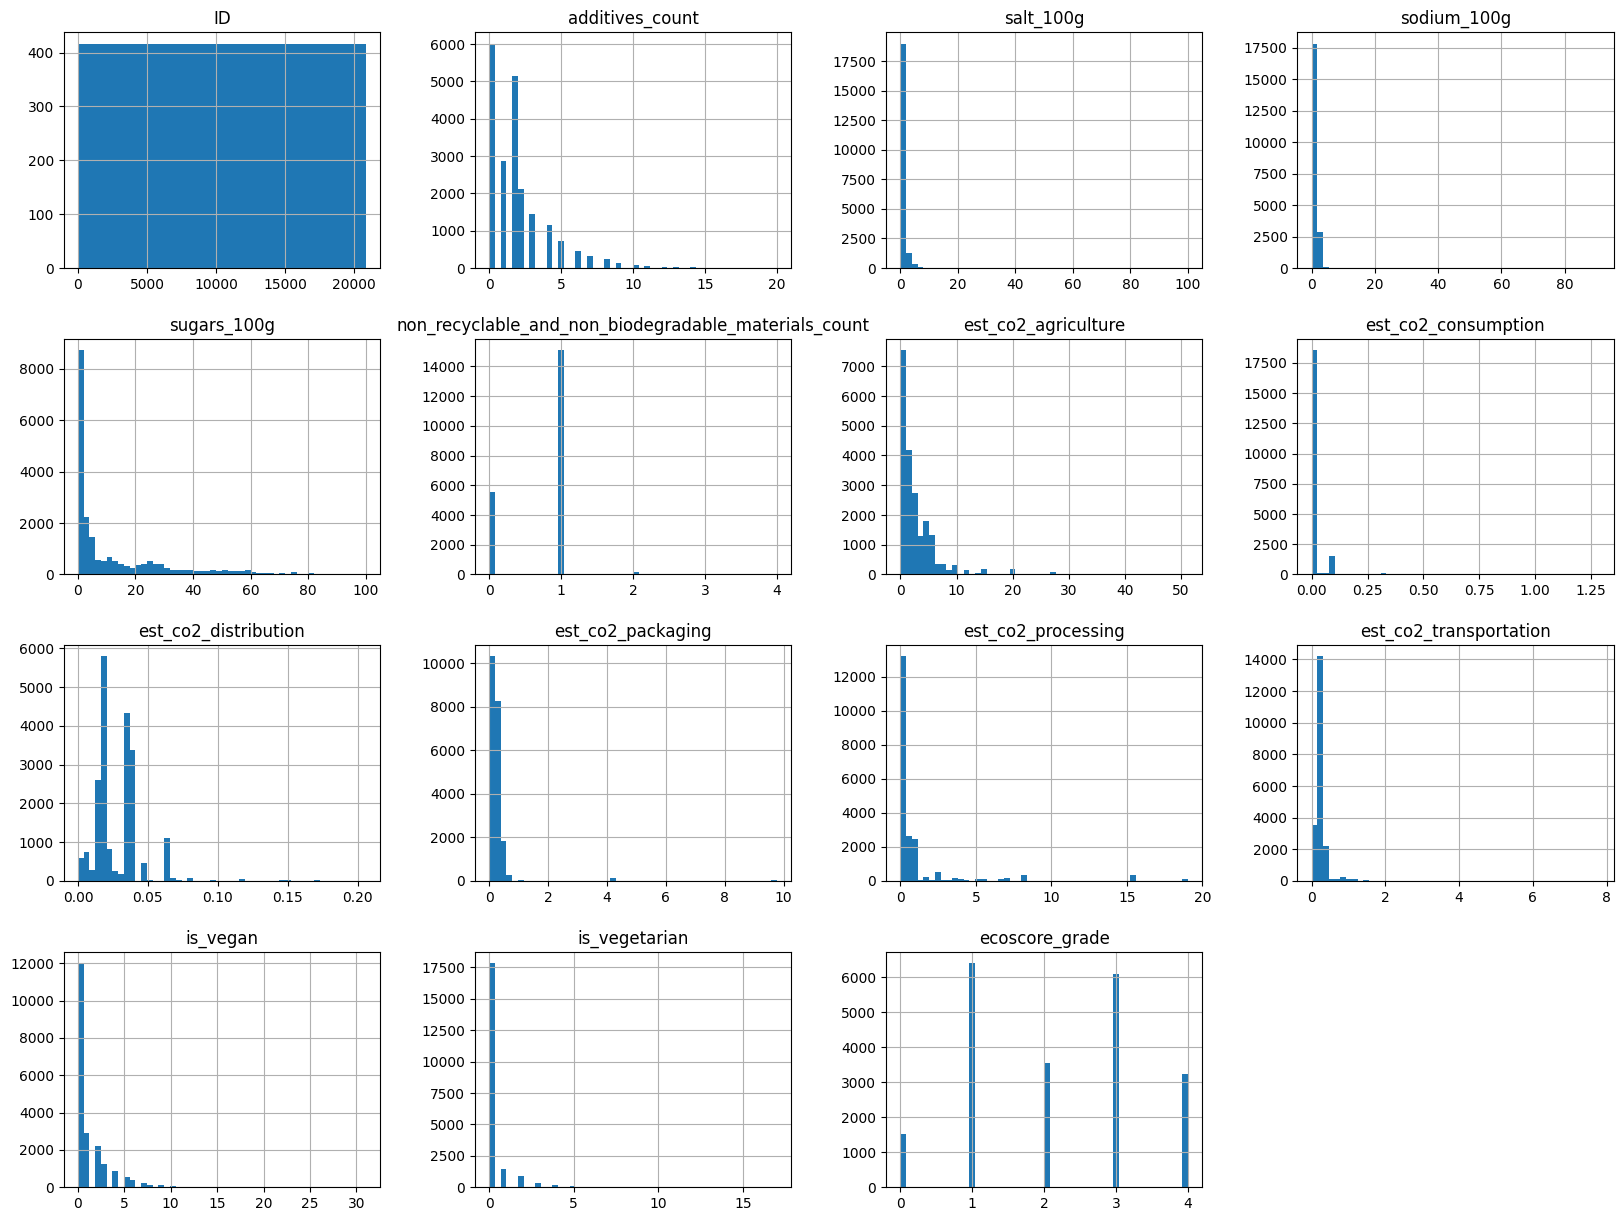

In [24]:
datos.hist(bins=50, figsize=(20,15))
plt.show()

Como las emisiones de $CO_2$ tienen una relación directa con el ecoscore de un producto, evaluemos su relación a través de un diagrama de barras apiladas:

## Agricultura

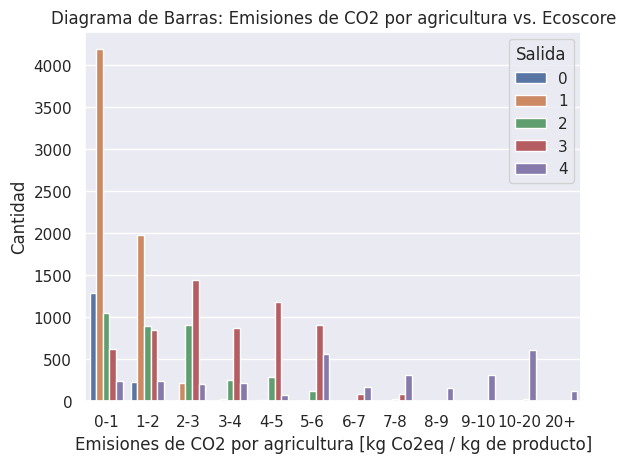

In [25]:
datos["co2_agriculture_segmentado"] = pd.cut(datos['est_co2_agriculture'], bins=[0, 1,2, 3, 4, 5, 6, 7,8, 9,10, 20, float('inf')],
                                  labels=['0-1','1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10','10-20','20+'])

sns.set(style="darkgrid")
sns.countplot(data=datos, x='co2_agriculture_segmentado', hue='ecoscore_grade')
plt.xlabel('Emisiones de CO2 por agricultura [kg Co2eq / kg de producto]')
plt.ylabel('Cantidad')
plt.title('Diagrama de Barras: Emisiones de CO2 por agricultura vs. Ecoscore')
plt.legend(title='Salida')
plt.show()

Notemos la tendencia interesante: para niveles de emisión de 0-1 kg CO2eq/ kg de producto la mayoría de ellos tienen un ecoscore de 1, sin embargo a medida que las emisiones aumentan, naturalmente el ecoscore también (un resultado lógico).

## Distribución

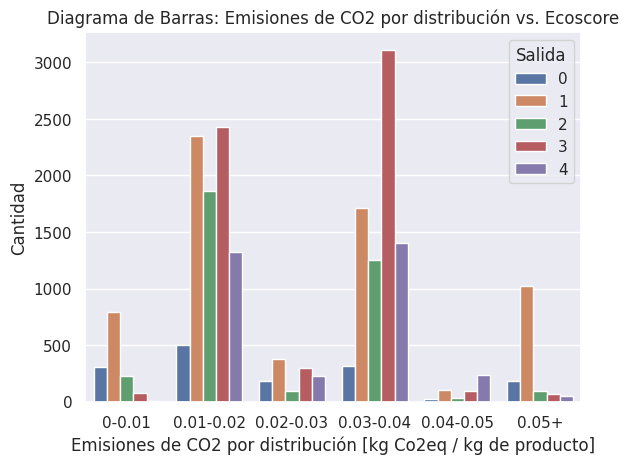

In [26]:
datos["co2_distribution_segmentado"] = pd.cut(datos['est_co2_distribution'], bins=[0, 0.01,0.02, 0.03, 0.04, 0.05, float('inf')],
                                  labels=['0-0.01','0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05+'])

sns.set(style="darkgrid")
sns.countplot(data=datos, x='co2_distribution_segmentado', hue='ecoscore_grade')
plt.xlabel('Emisiones de CO2 por distribución [kg Co2eq / kg de producto]')
plt.ylabel('Cantidad')
plt.title('Diagrama de Barras: Emisiones de CO2 por distribución vs. Ecoscore')
plt.legend(title='Salida')
plt.show()

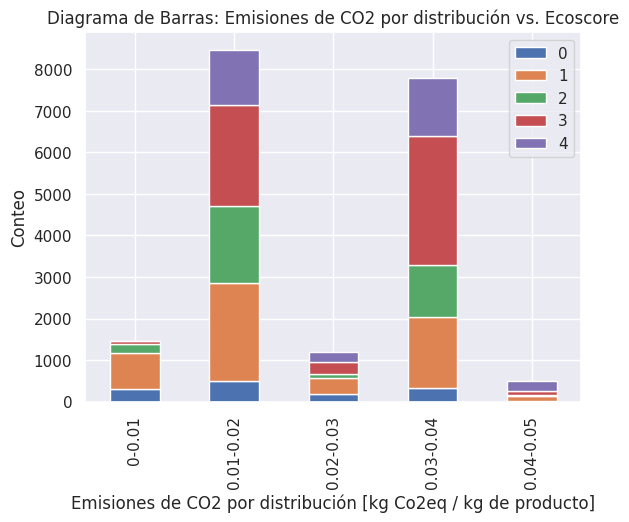

In [27]:
bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
labels = ['0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05']

datos['co2_range_d'] = pd.cut(datos['est_co2_distribution'], bins=bins, labels=labels, right=False)

# Contar las ocurrencias de cada combinación
counts = datos.groupby(['co2_range_d', 'ecoscore_grade']).size().unstack()

# Crear el diagrama de barras apiladas
counts.plot(kind='bar', stacked=True)

# Configurar los ejes y la leyenda
plt.xlabel('Emisiones de CO2 por distribución [kg Co2eq / kg de producto]')
plt.ylabel('Conteo')
plt.title('Diagrama de Barras: Emisiones de CO2 por distribución vs. Ecoscore')
plt.legend()

# Mostrar el diagrama
plt.show()



Notemos que en este caso aunque la tendencia no es tan clara, sí eviste un aumento en los productos con ecoscore_grade de 3 y 4 al aumentar el nivel de emisiones.

## Empaquetado

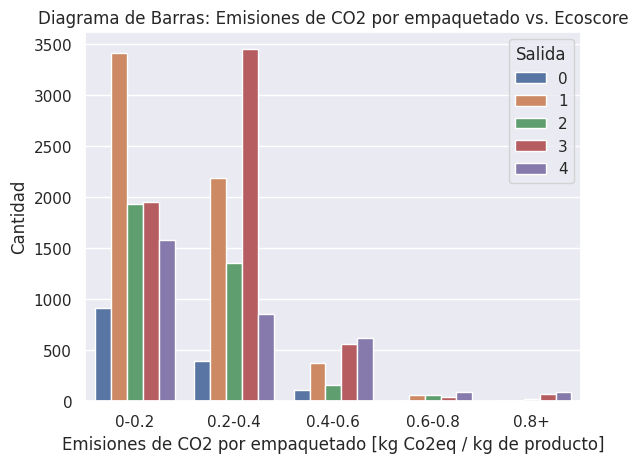

In [28]:
datos["co2_packaging_segmentado"] = pd.cut(datos['est_co2_packaging'], bins=[0, 0.2,0.4, 0.6, 0.8, float('inf')],
                                  labels=['0-0.2','0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8+'])

sns.set(style="darkgrid")
sns.countplot(data=datos, x='co2_packaging_segmentado', hue='ecoscore_grade')
plt.xlabel('Emisiones de CO2 por empaquetado [kg Co2eq / kg de producto]')
plt.ylabel('Cantidad')
plt.title('Diagrama de Barras: Emisiones de CO2 por empaquetado vs. Ecoscore')
plt.legend(title='Salida')
plt.show()

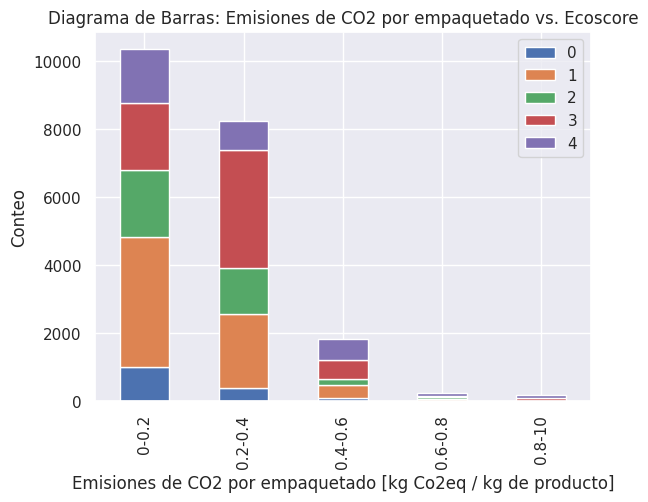

In [29]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 10]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-10']

datos['co2_range_p'] = pd.cut(datos['est_co2_packaging'], bins=bins, labels=labels, right=False)

# Contar las ocurrencias de cada combinación
counts = datos.groupby(['co2_range_p', 'ecoscore_grade']).size().unstack()

# Crear el diagrama de barras apiladas
counts.plot(kind='bar', stacked=True)

# Configurar los ejes y la leyenda
plt.xlabel('Emisiones de CO2 por empaquetado [kg Co2eq / kg de producto]')
plt.ylabel('Conteo')
plt.title('Diagrama de Barras: Emisiones de CO2 por empaquetado vs. Ecoscore')
plt.legend()

# Mostrar el diagrama
plt.show()

Nuevamente aunque el número de productos de los que se dispone con un mayor número de emisiones va en descenso, es fácil observar que la proporción de aquellos con un ecoscore_grade mayor va en aumento. Esperamos la misma tendencia para el resto de las emisiones.

## Procesado

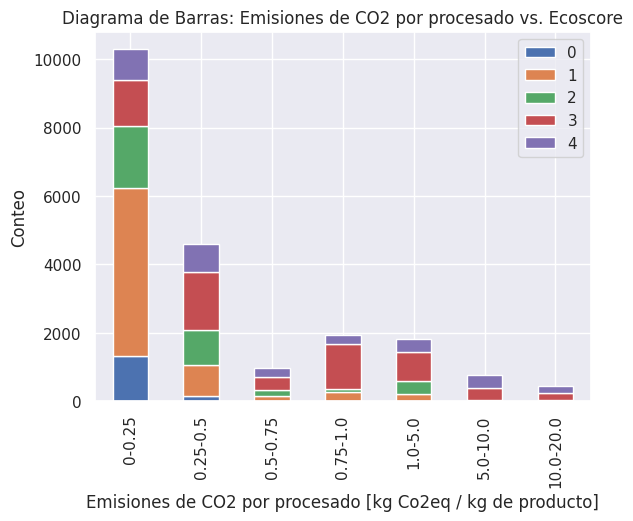

In [30]:
bins = [0, 0.25, 0.5, 0.75, 1.0, 5.0,10.0, 20.0]
labels = ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1.0', '1.0-5.0','5.0-10.0','10.0-20.0']

datos['co2_range_pr'] = pd.cut(datos['est_co2_processing'], bins=bins, labels=labels, right=False)

# Contar las ocurrencias de cada combinación
counts = datos.groupby(['co2_range_pr', 'ecoscore_grade']).size().unstack()

# Crear el diagrama de barras apiladas
counts.plot(kind='bar', stacked=True)

# Configurar los ejes y la leyenda
plt.xlabel('Emisiones de CO2 por procesado [kg Co2eq / kg de producto]')
plt.ylabel('Conteo')
plt.title('Diagrama de Barras: Emisiones de CO2 por procesado vs. Ecoscore')
plt.legend()

# Mostrar el diagrama
plt.show()

##Transporte

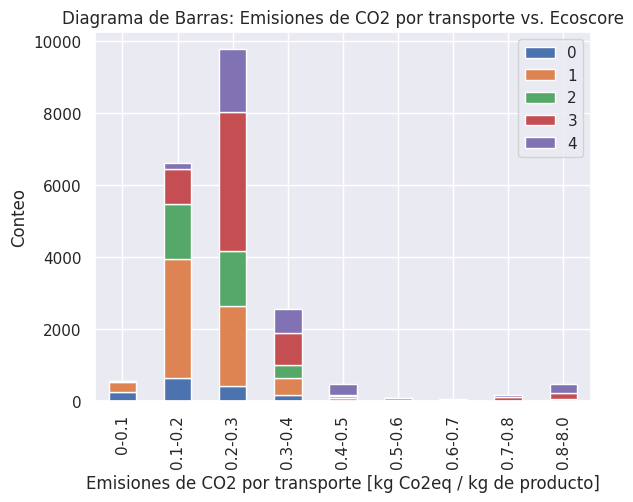

In [31]:
bins = [0, 0.1, 0.2, 0.3,0.4, 0.5,0.6,0.7, 0.8,8.0]
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5','0.5-0.6','0.6-0.7','0.7-0.8','0.8-8.0']

datos['co2_range_t'] = pd.cut(datos['est_co2_transportation'], bins=bins, labels=labels, right=False)

# Contar las ocurrencias de cada combinación
counts = datos.groupby(['co2_range_t', 'ecoscore_grade']).size().unstack()

# Crear el diagrama de barras apiladas
counts.plot(kind='bar', stacked=True)

# Configurar los ejes y la leyenda
plt.xlabel('Emisiones de CO2 por transporte [kg Co2eq / kg de producto]')
plt.ylabel('Conteo')
plt.title('Diagrama de Barras: Emisiones de CO2 por transporte vs. Ecoscore')
plt.legend()

# Mostrar el diagrama
plt.show()

## Consumo

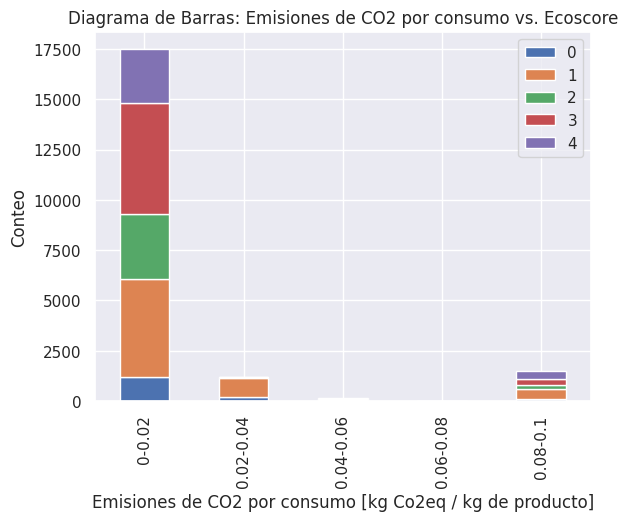

In [32]:
bins = [0, 0.02, 0.04, 0.06, 0.08,0.1]
labels = ['0-0.02', '0.02-0.04', '0.04-0.06', '0.06-0.08','0.08-0.1']

datos['co2_range_c'] = pd.cut(datos['est_co2_consumption'], bins=bins, labels=labels, right=False)

# Contar las ocurrencias de cada combinación de A_range y B
counts = datos.groupby(['co2_range_c', 'ecoscore_grade']).size().unstack()

# Crear el diagrama de barras apiladas
counts.plot(kind='bar', stacked=True)

# Configurar los ejes y la leyenda
plt.xlabel('Emisiones de CO2 por consumo [kg Co2eq / kg de producto]')
plt.ylabel('Conteo')
plt.title('Diagrama de Barras: Emisiones de CO2 por consumo vs. Ecoscore')
plt.legend()

# Mostrar el diagrama
plt.show()

Ahora evaluemos la correlación de las variables con el *ecoscore_grade* a través del coeficiente de correlación de Pearson:

<ipython-input-33-20c5049d8537>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  datos.corr()["ecoscore_grade"].sort_values(ascending= False).plot(kind = "bar", color= "darkgoldenrod")


Text(0.5, 1.0, 'Coeficiente de correlacción de Pearson de la variable ecoscore_grade con el resto de las variables')

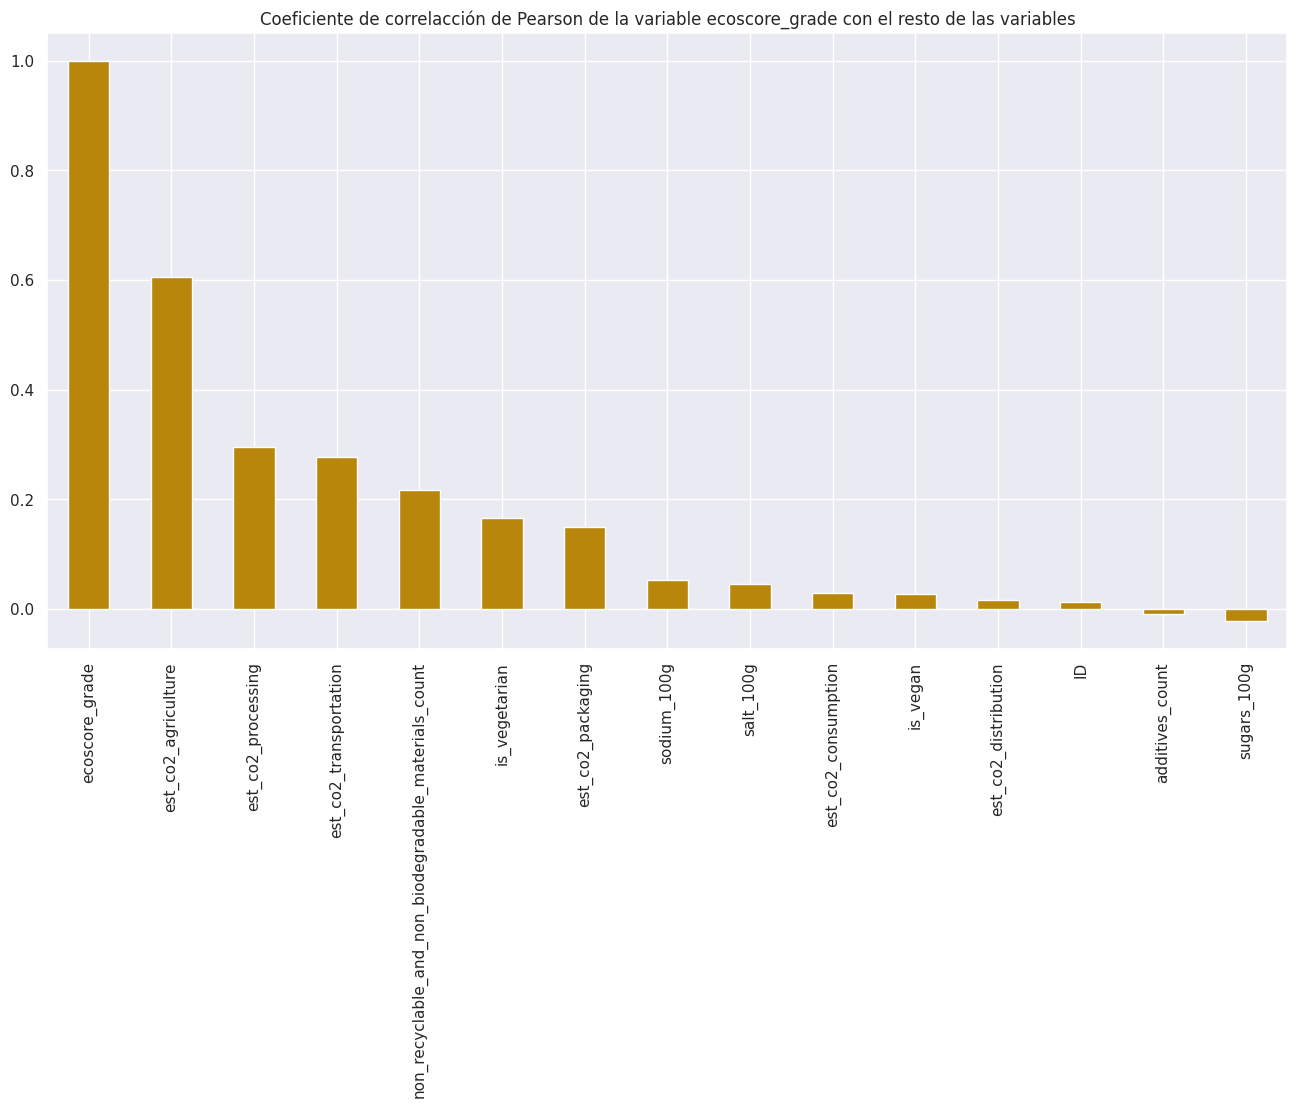

In [33]:
#Graficar la correlación entre y & el resto de las variables

plt.figure(figsize=(16,8))
datos.corr()["ecoscore_grade"].sort_values(ascending= False).plot(kind = "bar", color= "darkgoldenrod")
plt.title("Coeficiente de correlacción de Pearson de la variable ecoscore_grade con el resto de las variables")

##Implementación del modelo de regresión logística multinomial

In [56]:
# Separar las características (X) y la variable objetivo (y)
X = datos[['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation','non_recyclable_and_non_biodegradable_materials_count',
           'is_vegetarian','est_co2_packaging','est_co2_distribution','est_co2_consumption','is_vegan']]  # Características categóricas
y = datos['ecoscore_grade']  # Variable objetivo

#Crear el clasificador de regresión logísitica
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

#Ajustar el modelo a los datos de entrenamiento
model.fit(X, y)


#Obtener el conjunto de prueba

#lectura del archivo JSON

url = "https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Danone+Hackathon+Mexico/data/test_products.json"

response = requests.get(url)
prueba = response.json()


prueba1 = {}

#Creación de un nuevo diccionario con llaves enteras
for key, value in prueba.items():
  new_key= int(key)
  prueba1[new_key] = value

#Obtención de los datos que nos interesan (expresados arriba) en forma de listas
tid = prueba1.keys()
tadditives_count = [ prueba1[i]["additives_count"] for i in range (0,len(prueba1))]
tsalt_100g = [ prueba1[i]["salt_100g"] for i in range (0,len(prueba1))]
tsodium_100g = [ prueba1[i]["sodium_100g"] for i in range (0,len(prueba1))]
tsugars_100g = [ prueba1[i]["sugars_100g"] for i in range (0,len(prueba1))]
tnon_recyclable_and_non_biodegradable_materials_count = [ prueba1[i]["non_recyclable_and_non_biodegradable_materials_count"] for i in range (0,len(prueba1))]
test_co2_agriculture = [ prueba1[i]["est_co2_agriculture"] for i in range (0,len(prueba1))]
test_co2_consumption = [ prueba1[i]["est_co2_consumption"] for i in range (0,len(prueba1))]
test_co2_distribution = [ prueba1[i]["est_co2_distribution"] for i in range (0,len(prueba1))]
test_co2_packaging = [ prueba1[i]["est_co2_packaging"] for i in range (0,len(prueba1))]
test_co2_processing = [ prueba1[i]["est_co2_processing"] for i in range (0,len(prueba1))]
test_co2_transportation = [ prueba1[i]["est_co2_transportation"] for i in range (0,len(prueba1))]
tis_vegan=[]
tis_vegetarian=[]

#Conteo de ingredientes no-veganos y no-vegetarianos para cada producto
for j in range(0,len(prueba1)):
  not_vegan=0
  not_vegetarian =0
  for i  in prueba1[j]["ingredients"]:
    if "vegan" not in i:
      continue
    if i["vegan"] == "no":
      not_vegan += 1
    if i["vegetarian"] == "no":
      not_vegetarian += 1
  tis_vegan.append(not_vegan)
  tis_vegetarian.append(not_vegetarian)


#Transformar todas las entradas a número
tco2_agriculture = [float(i) for i in test_co2_agriculture]
tco2_consumption = [float(i) for i in test_co2_consumption]
tco2_distribution = [float(i) for i in test_co2_distribution]
tco2_packaging = [float(i) for i in test_co2_packaging]
tco2_processing = [float(i) for i in test_co2_processing]
tco2_transportation = [float(i) for i in test_co2_transportation]

#Quitar los valores unknown
# Cálculo de la media de los valores numéricos: additives
numeros = [i for i in tadditives_count if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
tadditives = [media if valor == "unknown" else valor for valor in tadditives_count]

# Cálculo de la media de los valores numéricos: salt
numeros1 = [i for i in tsalt_100g if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
tsalt = [media if valor == "unknown" else valor for valor in tsalt_100g]
tsalt_100g = [float(i) for i in tsalt]

# Cálculo de la media de los valores numéricos: sodium
numeros2 = [i for i in tsodium_100g if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
tsodium = [media if valor == "unknown" else valor for valor in tsodium_100g]
tsodium_100g = [float(i) for i in tsodium]

# Cálculo de la media de los valores numéricos: sugars
numeros3 = [i for i in tsugars_100g if isinstance(i, (int, float))]
media = sum(numeros) / len(numeros)

# Reemplazar "unknown" por la media
tsugars = [media if valor == "unknown" else valor for valor in tsugars_100g]
tsugars_100g = [float(i) for i in tsugars]

#Crear DataFrame de pandas

X_t = pd.DataFrame({
    "ID": tid,
    "additives_count": tadditives,
    "salt_100g": tsalt_100g,
    "sodium_100g": tsodium_100g,
    "sugars_100g": tsugars_100g,
    "non_recyclable_and_non_biodegradable_materials_count": tnon_recyclable_and_non_biodegradable_materials_count,
    "est_co2_agriculture": tco2_agriculture,
    "est_co2_consumption": tco2_consumption,
    "est_co2_distribution": tco2_distribution,
    "est_co2_packaging": tco2_packaging,
    "est_co2_processing": tco2_processing,
    "est_co2_transportation": tco2_transportation,
    "is_vegan": tis_vegan,
    "is_vegetarian": tis_vegetarian,
})

X_test=X_t[['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation','non_recyclable_and_non_biodegradable_materials_count',
           'is_vegetarian','est_co2_packaging','est_co2_distribution','est_co2_consumption','is_vegan']]

#Predicciones del modelo
y_pred = model.predict(X_test)

y_pred = y_pred.tolist()

# Crear el diccionario JSON con llaves entre comillas dobles
diccionario = {str(i): valor for i, valor in enumerate(y_pred)}

# Convertir el diccionario a JSON con llaves entre comillas dobles y sin espacios
json_string = json.dumps(diccionario, separators=(',', ':')).replace("'", '"')

# Guardar el JSON en un archivo
with open('/content/drive/MyDrive/data.json', 'w') as file:
    file.write(json_string)







Con este método se obtenía un F1-score de alrededor de *0.326* que variaba dependiendo de las variables categóricas incluidas. Recordemos que la regresión logística **solo captura relaciones lineales** y no considera aquellas que no lo son. Podemos observar que este modelo no es el más adecuado pues de la gráfica de barras de los índices de correlación de Pearson se observan valores de entre 0 y 0.6. En general podemos decir que existe una correlación importante cuando el índice está por encima de 0.3, lo cual solo se cumple para las variables de emisiones de carbono por agricultura y procesado.

## Decision tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

X = datos[['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation','non_recyclable_and_non_biodegradable_materials_count',
           'is_vegetarian','est_co2_packaging','est_co2_distribution','is_vegan']]  # Características categóricas
y = datos['ecoscore_grade']  # Variable objetivo

X_test=X_t[['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation','non_recyclable_and_non_biodegradable_materials_count',
           'is_vegetarian','est_co2_packaging','est_co2_distribution','is_vegan']]

# Crear una instancia del clasificador de árbol de decisión
clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=42)

# Entrenar el modelo
clf.fit(X, y)

# Realizar predicciones en los datos de prueba
y_pred_dt = clf.predict(X_test)

print(type(y_pred))

y_pred_dt = y_pred_dt.tolist()

# Crear el diccionario JSON con llaves entre comillas dobles
diccionario_dt = {str(i): valor for i, valor in enumerate(y_pred_dt)}

# Convertir el diccionario a JSON con llaves entre comillas dobles y sin espacios
json_string = json.dumps(diccionario_dt, separators=(',', ':')).replace("'", '"')

# Guardar el JSON en un archivo
with open('/content/drive/MyDrive/data_dt.json', 'w') as file:
    file.write(json_string)


<class 'list'>


## Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

X = datos[['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation','non_recyclable_and_non_biodegradable_materials_count',
           'is_vegetarian','est_co2_packaging']]  # Características categóricas
y = datos['ecoscore_grade']  # Variable objetivo

X_test=X_t[['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation','non_recyclable_and_non_biodegradable_materials_count',
           'is_vegetarian','est_co2_packaging']]

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X, y)

y_pred_rf = clf.predict(X_test)

print(type(y_pred_rf))

y_pred_rf = y_pred_rf.tolist()

# Crear el diccionario JSON con llaves entre comillas dobles
diccionario_rf = {str(i): valor for i, valor in enumerate(y_pred_rf)}

# Convertir el diccionario a JSON con llaves entre comillas dobles y sin espacios
json_string = json.dumps(diccionario_dt, separators=(',', ':')).replace("'", '"')

# Guardar el JSON en un archivo
with open('/content/drive/MyDrive/data_rf.json', 'w') as file:
    file.write(json_string)




<class 'numpy.ndarray'>


##Conclusiones

Al evaluar los modelos de decision tree y RandomForest obtenemos F1 scores de alrededor de 0.32 para ambos casos (scores muy parecidos a los de la regresión logística multinomial). Estos nos indica que hace falta capturar mayor información, por ejemplo, podemos incluir la lista de materiales con que se fabricó el envase *packaging_materials* o *hierarchy_distribution*, variable que podría estar relacionada con los costos de almacenamiento pues describe la categoría del producto (snack, alimento congelado, etc).

Estas representan áreas de oportunidad para aumentar la eficiencia del modelo.